In [22]:
import pandas as pd
import numpy as np
import supervision as sv
import os
from tqdm.notebook import tqdm

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"supervision version: {sv.__version__}")

pandas version: 2.2.3
numpy version: 1.26.4
supervision version: 0.26.1


In [23]:
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
CLASS_NAMES = {
    0: "CFCBK",
    1: "FCBK",
    2: "Zigzag"
}
NUM_CLASSES = len(CLASS_NAMES)

# Assumes your notebook and the CSV files are in the same directory
# If not, change this path accordingly
CSV_BASE_PATH = '.' 

# Confidence threshold for including a prediction in the metrics
CONFIDENCE_THRESHOLD = 0.05

In [6]:
def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05) -> (list, list):
    """
    Loads ground truth and prediction data from a CSV file into supervision.Detections objects.

    Args:
        csv_path (str): The path to the input CSV file.
        confidence_threshold (float): The minimum score for a prediction to be included.

    Returns:
        A tuple containing two lists:
        - List of supervision.Detections for ground truth.
        - List of supervision.Detections for predictions.
    """
    df = pd.read_csv(csv_path)

    # It's critical to sort the image names to ensure GT and predictions are aligned.
    image_names = sorted(df['image_name'].unique())
    
    targets = []
    predictions = []

    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
        img_df = df[df['image_name'] == img_name]

        # --- Process Ground Truth ---
        gt_df = img_df[img_df['box_type'] == 'ground_truth']
        if not gt_df.empty:
            gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            # Convert 1-based class_id from CSV to 0-based index
            gt_class_ids = (gt_df['class_id'].values - 1).astype(int)
            
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_class_ids
            )
        else:
            # Create empty detection object if no ground truth exists for this image
            gt_detections = sv.Detections.empty()
        
        targets.append(gt_detections)

        # --- Process Predictions ---
        pred_df = img_df[img_df['box_type'] == 'prediction']
        # Apply confidence threshold
        pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]

        if not pred_df.empty:
            pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            # Convert 1-based class_id from CSV to 0-based index
            pred_class_ids = (pred_df['class_id'].values - 1).astype(int)
            pred_scores = pred_df['confidence_score'].values

            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_class_ids,
                confidence=pred_scores
            )
        else:
            # Create empty detection object if no predictions exist for this image
            pred_detections = sv.Detections.empty()
            
        predictions.append(pred_detections)

    return targets, predictions

In [ ]:
# Convert results list to a DataFrame for pretty printing
results_df = pd.DataFrame(all_results)

# --- Display DataFrame ---
print("--- Model Performance Benchmark ---")
display(results_df.round(2))


# --- Display in LaTeX Table Format ---
print("\n--- LaTeX Formatted Output ---")
for _, row in results_df.iterrows():
    model_key = row['Model']
    ca_map_50_val = row['CA mAP@50']
    class_maps = [row[f'{CLASS_NAMES[i]} mAP@50'] for i in range(NUM_CLASSES)]
    
    # Format: Model & CA_mAP & Class1_mAP & Class2_mAP & Class3_mAP \\
    formatted_output = f"{model_key} & {ca_map_50_val:.2f} & " + " & ".join([f"{val:.2f}" for val in class_maps]) + " \\\\"
    print(formatted_output)

In [ ]:
# import os
# import pandas as pd
# from tqdm import tqdm
# from supervision.metrics.mean_average_precision import MeanAveragePrecision
# import supervision as sv

# MODEL_NAMES = ['terramind', 'galileo', 'satmae']
# CLASS_NAMES = ["CFCBK", "FCBK", "Zigzag"]
# NUM_CLASSES = len(CLASS_NAMES)
# CLASSES = CLASS_NAMES  # For supervision ConfusionMatrix

# CSV_BASE_PATH = '.'
# CONFIDENCE_THRESHOLD = 0.05

# def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05) -> (list, list):
#     df = pd.read_csv(csv_path)
#     image_names = sorted(df['image_name'].unique())
#     targets, predictions = [], []

#     for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
#         img_df = df[df['image_name'] == img_name]
#         # --- Process Ground Truth ---
#         gt_df = img_df[img_df['box_type'] == 'ground_truth']
#         if not gt_df.empty:
#             gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
#             gt_class_ids = (gt_df['class_id'].values - 1).astype(int)  # 0-based index
#             gt_detections = sv.Detections(
#                 xyxy=gt_boxes,
#                 class_id=gt_class_ids
#             )
#         else:
#             gt_detections = sv.Detections.empty()
#         targets.append(gt_detections)
#         # --- Process Predictions ---
#         pred_df = img_df[img_df['box_type'] == 'prediction']
#         pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]
#         if not pred_df.empty:
#             pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
#             pred_class_ids = (pred_df['class_id'].values - 1).astype(int)  # 0-based index
#             pred_scores = pred_df['confidence_score'].values
#             pred_detections = sv.Detections(
#                 xyxy=pred_boxes,
#                 class_id=pred_class_ids,
#                 confidence=pred_scores
#             )
#         else:
#             pred_detections = sv.Detections.empty()
#         predictions.append(pred_detections)

#     return targets, predictions

# all_results = []
# markdown_rows = []
# cm_markdown_rows = []

# for model_name in MODEL_NAMES:
#     print(f"\n--- Evaluating model: {model_name} ---")
#     csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
#     if not os.path.exists(csv_file):
#         print(f"Warning: CSV file not found for {model_name} at {csv_file}. Skipping.")
#         continue

#     # Load detections
#     targets, predictions = load_detections_from_csv(csv_file, confidence_threshold=CONFIDENCE_THRESHOLD)

#     # === mAP Metrics ===
#     map_metric_cw = MeanAveragePrecision(class_agnostic=False)
#     map_metric_cw.update(predictions=predictions, targets=targets)
#     class_wise_results = map_metric_cw.compute()
#     final_class_wise_mAP_50 = [0.0] * NUM_CLASSES
#     final_class_wise_mAP_50_90 = [0.0] * NUM_CLASSES

#     if class_wise_results.ap_per_class.shape[1] > 1:
#         map_per_class_list_50 = class_wise_results.ap_per_class[:, 0].tolist()
#         map_per_class_list_50_90 = class_wise_results.ap_per_class[:, 1].tolist()
#     else:
#         map_per_class_list_50 = class_wise_results.ap_per_class[:, 0].tolist()
#         map_per_class_list_50_90 = [0.0] * NUM_CLASSES  # Fallback

#     matched_classes = class_wise_results.matched_classes
#     for class_id, map50, map50_90 in zip(matched_classes, map_per_class_list_50, map_per_class_list_50_90):
#         if class_id < NUM_CLASSES:
#             final_class_wise_mAP_50[class_id] = map50 * 100
#             final_class_wise_mAP_50_90[class_id] = map50_90 * 100

#     map_metric_ca = MeanAveragePrecision(class_agnostic=True)
#     map_metric_ca.update(predictions=predictions, targets=targets)
#     class_agnostic_results = map_metric_ca.compute()
#     ca_map_50 = class_agnostic_results.map50 * 100
#     ca_map_50_90 = class_agnostic_results.map50_95 * 100 if hasattr(class_agnostic_results, 'map50_95') else 0.0

#     # === Confusion Matrix ===
#     iou_threshold = 0.50
#     conf_threshold = 0.05
#     confusion_matrix = sv.ConfusionMatrix.from_detections(
#         predictions=predictions,
#         targets=targets,
#         classes=CLASSES,
#         conf_threshold=conf_threshold,
#         iou_threshold=iou_threshold
#     )
#     cm = confusion_matrix.matrix
#     tp_per_class = [cm[i][i] for i in range(NUM_CLASSES)]
#     tp_total = sum(tp_per_class)
#     predicted_positives_total = cm.sum(axis=0).sum()
#     actual_positives_total = cm.sum(axis=1).sum()
#     precision = tp_total / (predicted_positives_total + 1e-9)
#     recall = tp_total / (actual_positives_total + 1e-9)
#     f1_score = 2 * precision * recall / (precision + recall + 1e-9)
#     false_positives = predicted_positives_total - tp_total
#     false_negatives = actual_positives_total - tp_total

#     # === Store Row for Tables ===
#     markdown_rows.append([
#         model_name.capitalize(),
#         f"{ca_map_50:.2f}",
#         f"{final_class_wise_mAP_50[0]:.2f}",
#         f"{final_class_wise_mAP_50[1]:.2f}",
#         f"{final_class_wise_mAP_50[2]:.2f}",
#         f"{ca_map_50_90:.2f}",
#         f"{final_class_wise_mAP_50_90[0]:.2f}",
#         f"{final_class_wise_mAP_50_90[1]:.2f}",
#         f"{final_class_wise_mAP_50_90[2]:.2f}",
#     ])
#     cm_markdown_rows.append([
#         model_name.capitalize(),
#         f"{iou_threshold:.2f}",
#         f"{precision * 100:.2f}",
#         f"{recall * 100:.2f}",
#         f"{f1_score * 100:.2f}",
#         str(int(tp_total)),
#         str(int(false_positives)),
#         str(int(false_negatives)),
#         str(int(actual_positives_total))
#     ])
#     all_results.append({
#         "Model": model_name.capitalize(),
#         "CA mAP@50": ca_map_50,
#         f"{CLASS_NAMES[0]} mAP@50": final_class_wise_mAP_50[0],
#         f"{CLASS_NAMES[1]} mAP@50": final_class_wise_mAP_50[1],
#         f"{CLASS_NAMES[2]} mAP@50": final_class_wise_mAP_50[2],
#         "Precision@50": precision * 100,
#         "Recall@50": recall * 100,
#         "F1@50": f1_score * 100,
#         "False Positives": false_positives,
#         "False Negatives": false_negatives
#     })

# print("\n✅ Evaluation complete for all models.")

# # === Print Markdown Tables ===
# header1 = ["Model", "Class Agonostics mAP@50", "CFCBK@50", "FCBK@50", "Zigzag@50", 
#            "Class Agonostics mAP@50_90", "CFCBK@50_90", "FCBK@50_90", "Zigzag@50_90"]
# print("\n### mAP Table")
# print("| " + " | ".join(header1) + " |")
# print("|" + "----|" * len(header1))
# for row in markdown_rows:
#     print("| " + " | ".join(row) + " |")

# header2 = ["Model", "IoU", "Precision", "Recall", "F1 score", "TP", "FP", "FN"]
# print("\n### Confusion Matrix Table")
# print("| " + " | ".join(header2) + " |")
# print("|" + "----|" * len(header2))
# for row in cm_markdown_rows:
#     print("| " + " | ".join(row) + " |")



--- Evaluating model: terramind ---


Processing test_results_terramind.csv: 100%|██████████| 15590/15590 [01:51<00:00, 139.59it/s]



--- Evaluating model: galileo ---


Processing test_results_galileo.csv: 100%|██████████| 15590/15590 [02:00<00:00, 129.27it/s]



--- Evaluating model: satmae ---


Processing test_results_satmae.csv: 100%|██████████| 15590/15590 [01:09<00:00, 225.02it/s]



✅ Evaluation complete for all models.

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| Terramind | 85.37 | 72.75 | 72.45 | 76.86 | 45.37 | 72.25 | 70.72 | 74.81 |
| Galileo | 84.78 | 71.34 | 73.08 | 77.06 | 44.02 | 70.12 | 71.35 | 74.55 |
| Satmae | 81.55 | 53.37 | 59.63 | 65.06 | 39.89 | 49.82 | 57.34 | 62.51 |

### Confusion Matrix Table
| Model | IoU | Precision | Recall | F1 score | TP | FP | FN | Kiln instances |
|----|----|----|----|----|----|----|----|----|
| Terramind | 0.50 | 19.11 | 19.11 | 19.11 | 13475 | 57029 | 57029 | 70504 |
| Galileo | 0.50 | 16.47 | 16.47 | 16.47 | 13139 | 66626 | 66626 | 79765 |
| Satmae | 0.50 | 48.74 | 48.74 | 48.74 | 14969 | 15740 | 15740 | 30709 |


In [2]:
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
CLASS_NAMES = ["CFCBK", "FCBK", "Zigzag"]
NUM_CLASSES = len(CLASS_NAMES)
CLASSES = CLASS_NAMES  # For supervision ConfusionMatrix
CSV_BASE_PATH = '.'
CONFIDENCE_THRESHOLD = 0.05
IOU_THRESHOLD = 0.50



In [4]:
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
# CLASS_NAMES = {
#     0: "CFCBK",
#     1: "FCBK",
#     2: "Zigzag"
# }
# NUM_CLASSES = len(CLASS_NAMES)

# # Assumes your notebook and the CSV files are in the same directory
# If not, change this path accordingly
CSV_BASE_PATH = '.' 

# Confidence threshold for including a prediction in the metrics
CONFIDENCE_THRESHOLD = 0.05

| Model | TP | FP | FN | Precision | Recall | F1 |
|-------|----|----|----|-----------|--------|----|

--- terramind ---


Processing test_results_terramind.csv: 100%|██████████| 15590/15590 [01:51<00:00, 140.30it/s]


| terramind | 13475 | 49608 | 794 | 0.214 | 0.944 | 0.348 |
Class CFCBK: TP=524, FP=3846, FN=123, Prec=0.120, Rec=0.810, F1=0.209


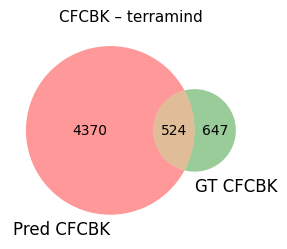

Class FCBK: TP=7006, FP=30476, FN=4102, Prec=0.187, Rec=0.631, F1=0.288


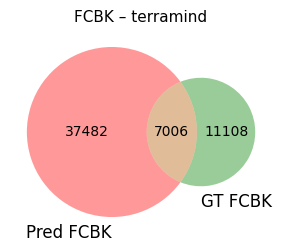

Class Zigzag: TP=5945, FP=21913, FN=3196, Prec=0.213, Rec=0.650, F1=0.321


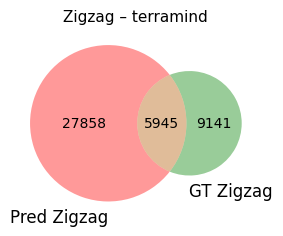


--- galileo ---


Processing test_results_galileo.csv: 100%|██████████| 15590/15590 [02:01<00:00, 128.74it/s]


| galileo | 13139 | 58869 | 846 | 0.182 | 0.940 | 0.306 |
Class CFCBK: TP=507, FP=2696, FN=140, Prec=0.158, Rec=0.784, F1=0.263


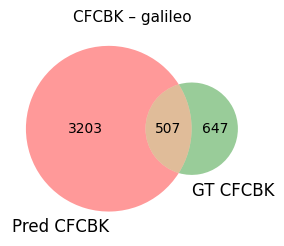

Class FCBK: TP=6955, FP=36733, FN=4153, Prec=0.159, Rec=0.626, F1=0.254


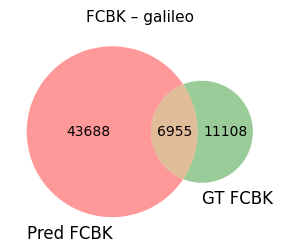

Class Zigzag: TP=5677, FP=26351, FN=3464, Prec=0.177, Rec=0.621, F1=0.276


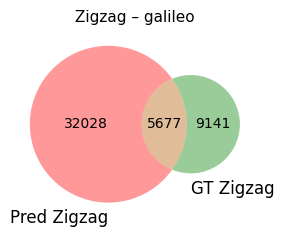


--- satmae ---


Processing test_results_satmae.csv: 100%|██████████| 15590/15590 [01:07<00:00, 230.84it/s]


| satmae | 14969 | 9813 | 2278 | 0.604 | 0.868 | 0.712 |
Class CFCBK: TP=375, FP=440, FN=272, Prec=0.460, Rec=0.580, F1=0.513


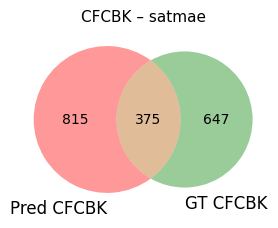

Class FCBK: TP=7907, FP=7212, FN=3201, Prec=0.523, Rec=0.712, F1=0.603


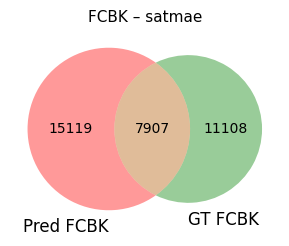

Class Zigzag: TP=6687, FP=5810, FN=2454, Prec=0.535, Rec=0.732, F1=0.618


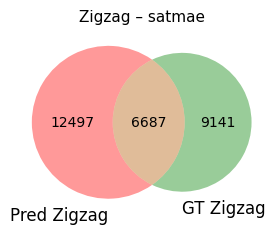

In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# CSV_BASE_PATH = "."  # adjust as needed
# MODEL_NAMES = ["yolov11_obb", "rtdetr", "yolov12", "yolo_world"]  # define your models here!
# CLASSES = ["CFCBK", "FCBK", "Zigzag"]
# NUM_CLASSES = len(CLASSES)
# CONFIDENCE_THRESHOLD = 0.05
# IOU_THRESHOLD = 0.50

def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05):
    df = pd.read_csv(csv_path)
    image_names = sorted(df['image_name'].unique())
    targets, predictions = [], []

    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
        img_df = df[df['image_name'] == img_name]

        # --- Ground Truth ---
        gt_df = img_df[img_df['box_type'] == 'ground_truth']
        if not gt_df.empty:
            gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            gt_class_ids = (gt_df['class_id'].values - 1).astype(int)
            gt_confidence = np.ones(len(gt_class_ids), dtype=np.float32)
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_class_ids,
                confidence=gt_confidence
            )
        else:
            gt_detections = sv.Detections.empty()
        targets.append(gt_detections)

        # --- Predictions ---
        pred_df = img_df[img_df['box_type'] == 'prediction']
        pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]
        if not pred_df.empty:
            pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            pred_class_ids = (pred_df['class_id'].values - 1).astype(int)
            pred_scores = pred_df['confidence_score'].values
            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_class_ids,
                confidence=pred_scores
            )
        else:
            pred_detections = sv.Detections.empty()
        predictions.append(pred_detections)

    return predictions, targets

print("| Model | TP | FP | FN | Precision | Recall | F1 |")
print("|-------|----|----|----|-----------|--------|----|")

for model_name in MODEL_NAMES:
    print(f"\n--- {model_name} ---")
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    predictions, targets = load_detections_from_csv(csv_file, confidence_threshold=CONFIDENCE_THRESHOLD)

    # Build multiclass confusion matrix
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=CONFIDENCE_THRESHOLD,
        iou_threshold=IOU_THRESHOLD
    )
    cm = confusion_matrix.matrix  # shape (num_classes+1, num_classes)

    # Class-agnostic metrics
    tp = int(sum(cm[i, i] for i in range(NUM_CLASSES)))
    fp = int(cm[-1, :NUM_CLASSES].sum())
    fn = int(cm[:NUM_CLASSES, -1].sum())

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    print(f"| {model_name} | {tp} | {fp} | {fn} | {precision:.3f} | {recall:.3f} | {f1:.3f} |")

    # --- Per-class metrics and Venn diagrams ---
    for k in range(NUM_CLASSES):
        tp_k = int(cm[k, k])
        fp_k = int(cm[:, k].sum() - cm[k, k])  # predicted as class k, not correct
        fn_k = int(cm[k, :].sum() - cm[k, k])  # GT class k, not predicted as k
        precision_k = tp_k / (tp_k + fp_k + 1e-9)
        recall_k = tp_k / (tp_k + fn_k + 1e-9)
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k + 1e-9)
        print(f"Class {CLASSES[k]}: TP={tp_k}, FP={fp_k}, FN={fn_k}, Prec={precision_k:.3f}, Rec={recall_k:.3f}, F1={f1_k:.3f}")

        gt_total = int(cm[k, :].sum())
        pred_total = int(cm[:, k].sum())
        tp = tp_k

        plt.figure(figsize=(3, 3))
        venn2(
            subsets=(pred_total, gt_total, tp),
            set_labels=(f"Pred {CLASSES[k]}", f"GT {CLASSES[k]}")
        )
        plt.title(f"{CLASSES[k]} – {model_name}", fontsize=11)
        plt.tight_layout()
        plt.show()


In [6]:
def box_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-9)
    return iou


| Model | TP | FP | FN | Precision | Recall | F1 |
|-------|----|----|----|-----------|--------|----|

--- terramind ---


Processing test_results_terramind.csv: 100%|██████████| 15590/15590 [01:53<00:00, 137.37it/s]


| terramind | 13475 | 49608 | 794 | 0.214 | 0.944 | 0.348 |
Class CFCBK: TP=524, FP=3846, FN=123, Prec=0.120, Rec=0.810, F1=0.209


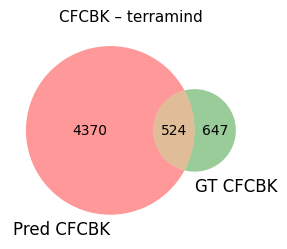

Class FCBK: TP=7006, FP=30476, FN=4102, Prec=0.187, Rec=0.631, F1=0.288


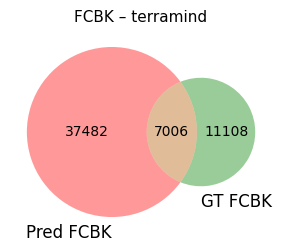

Class Zigzag: TP=5945, FP=21913, FN=3196, Prec=0.213, Rec=0.650, F1=0.321


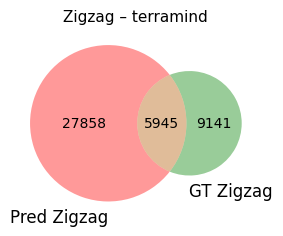

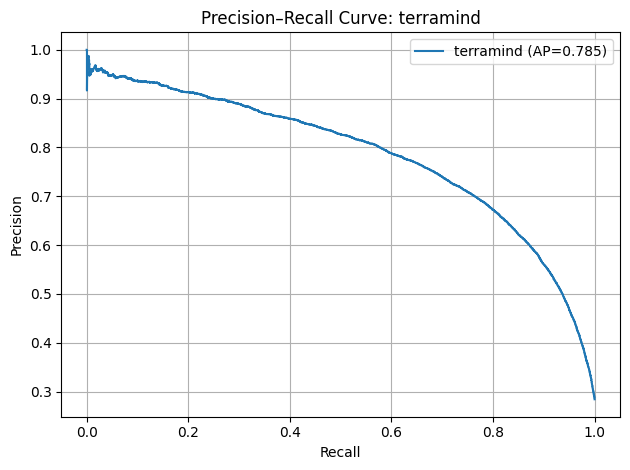


--- galileo ---


Processing test_results_galileo.csv: 100%|██████████| 15590/15590 [02:06<00:00, 123.71it/s]


| galileo | 13139 | 58869 | 846 | 0.182 | 0.940 | 0.306 |
Class CFCBK: TP=507, FP=2696, FN=140, Prec=0.158, Rec=0.784, F1=0.263


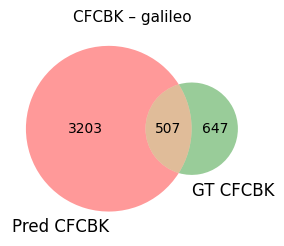

Class FCBK: TP=6955, FP=36733, FN=4153, Prec=0.159, Rec=0.626, F1=0.254


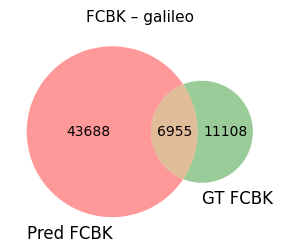

Class Zigzag: TP=5677, FP=26351, FN=3464, Prec=0.177, Rec=0.621, F1=0.276


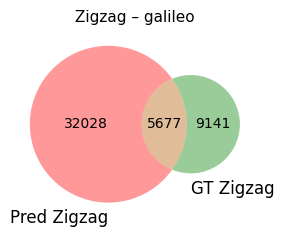

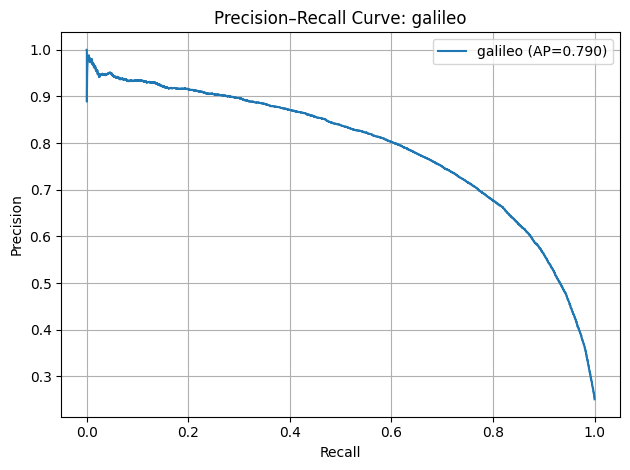


--- satmae ---


Processing test_results_satmae.csv: 100%|██████████| 15590/15590 [01:10<00:00, 220.22it/s]


| satmae | 14969 | 9813 | 2278 | 0.604 | 0.868 | 0.712 |
Class CFCBK: TP=375, FP=440, FN=272, Prec=0.460, Rec=0.580, F1=0.513


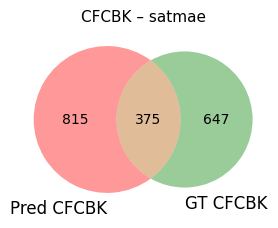

Class FCBK: TP=7907, FP=7212, FN=3201, Prec=0.523, Rec=0.712, F1=0.603


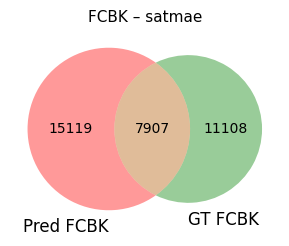

Class Zigzag: TP=6687, FP=5810, FN=2454, Prec=0.535, Rec=0.732, F1=0.618


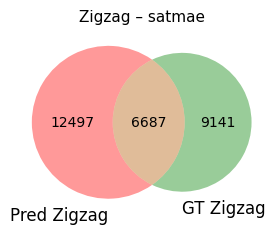

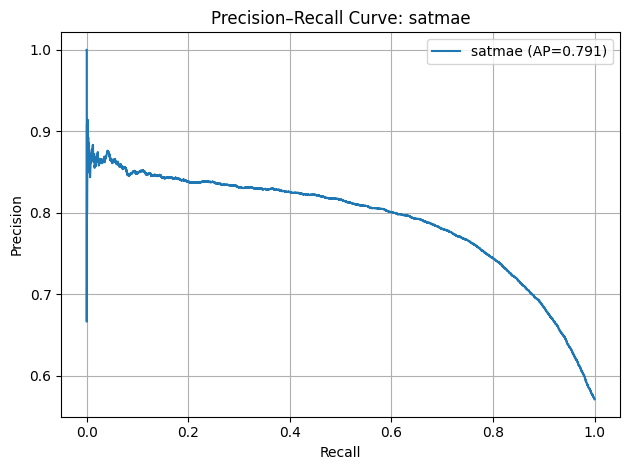

In [7]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.metrics import precision_recall_curve, auc

def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05):
    df = pd.read_csv(csv_path)
    image_names = sorted(df['image_name'].unique())
    targets, predictions = [], []

    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
        img_df = df[df['image_name'] == img_name]

        # --- Ground Truth ---
        gt_df = img_df[img_df['box_type'] == 'ground_truth']
        if not gt_df.empty:
            gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            gt_class_ids = (gt_df['class_id'].values - 1).astype(int)
            gt_confidence = np.ones(len(gt_class_ids), dtype=np.float32)
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_class_ids,
                confidence=gt_confidence
            )
        else:
            gt_detections = sv.Detections.empty()
        targets.append(gt_detections)

        # --- Predictions ---
        pred_df = img_df[img_df['box_type'] == 'prediction']
        pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]
        if not pred_df.empty:
            pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            pred_class_ids = (pred_df['class_id'].values - 1).astype(int)
            pred_scores = pred_df['confidence_score'].values
            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_class_ids,
                confidence=pred_scores
            )
        else:
            pred_detections = sv.Detections.empty()
        predictions.append(pred_detections)

    return predictions, targets

print("| Model | TP | FP | FN | Precision | Recall | F1 |")
print("|-------|----|----|----|-----------|--------|----|")

for model_name in MODEL_NAMES:
    print(f"\n--- {model_name} ---")
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    predictions, targets = load_detections_from_csv(csv_file, confidence_threshold=CONFIDENCE_THRESHOLD)

    # Build multiclass confusion matrix
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=CONFIDENCE_THRESHOLD,
        iou_threshold=IOU_THRESHOLD
    )
    cm = confusion_matrix.matrix  # shape (num_classes+1, num_classes)

    # Class-agnostic metrics
    tp = int(sum(cm[i, i] for i in range(NUM_CLASSES)))
    fp = int(cm[-1, :NUM_CLASSES].sum())
    fn = int(cm[:NUM_CLASSES, -1].sum())

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    print(f"| {model_name} | {tp} | {fp} | {fn} | {precision:.3f} | {recall:.3f} | {f1:.3f} |")

    # --- Per-class metrics and Venn diagrams ---
    for k in range(NUM_CLASSES):
        tp_k = int(cm[k, k])
        fp_k = int(cm[:, k].sum() - cm[k, k])
        fn_k = int(cm[k, :].sum() - cm[k, k])
        precision_k = tp_k / (tp_k + fp_k + 1e-9)
        recall_k = tp_k / (tp_k + fn_k + 1e-9)
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k + 1e-9)
        print(f"Class {CLASSES[k]}: TP={tp_k}, FP={fp_k}, FN={fn_k}, Prec={precision_k:.3f}, Rec={recall_k:.3f}, F1={f1_k:.3f}")

        gt_total = int(cm[k, :].sum())
        pred_total = int(cm[:, k].sum())
        tp = tp_k

        plt.figure(figsize=(3, 3))
        venn2(
            subsets=(pred_total, gt_total, tp),
            set_labels=(f"Pred {CLASSES[k]}", f"GT {CLASSES[k]}")
        )
        plt.title(f"{CLASSES[k]} – {model_name}", fontsize=11)
        plt.tight_layout()
        plt.show()

    # --- Precision-Recall Curve + AUC (class-agnostic) ---
    all_scores = []
    all_labels = []

    for pred, gt in zip(predictions, targets):
        for cls in range(NUM_CLASSES):
            cls_preds = pred[cls == pred.class_id]
            cls_gts = gt[cls == gt.class_id]
            matched_gt_indices = set()
            matched_pred_indices = set()

            for i, pred_box in enumerate(cls_preds.xyxy):
                best_iou = 0
                best_gt_idx = -1
                for j, gt_box in enumerate(cls_gts.xyxy):
                    if j in matched_gt_indices:
                        continue
                    iou = box_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j
                if best_iou >= IOU_THRESHOLD:
                    matched_pred_indices.add(i)
                    matched_gt_indices.add(best_gt_idx)


            for i, score in enumerate(cls_preds.confidence):
                all_scores.append(score)
                all_labels.append(1 if i in matched_pred_indices else 0)

    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_scores)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f"{model_name} (AP={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


| Model | TP | FP | FN | Precision | Recall | F1 |
|-------|----|----|----|-----------|--------|----|

--- terramind ---


Processing test_results_terramind.csv: 100%|██████████| 15590/15590 [01:54<00:00, 135.72it/s]


| terramind | 13475 | 49608 | 794 | 0.214 | 0.944 | 0.348 |
Class CFCBK: TP=524, FP=3846, FN=123, Prec=0.120, Rec=0.810, F1=0.209


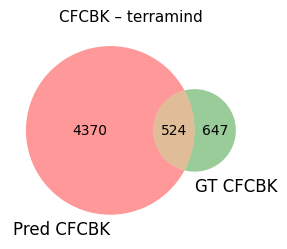

Class FCBK: TP=7006, FP=30476, FN=4102, Prec=0.187, Rec=0.631, F1=0.288


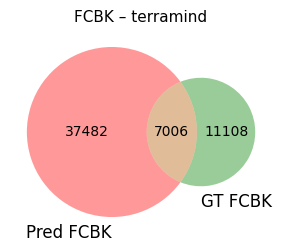

Class Zigzag: TP=5945, FP=21913, FN=3196, Prec=0.213, Rec=0.650, F1=0.321


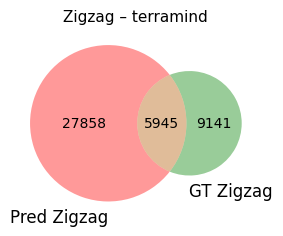

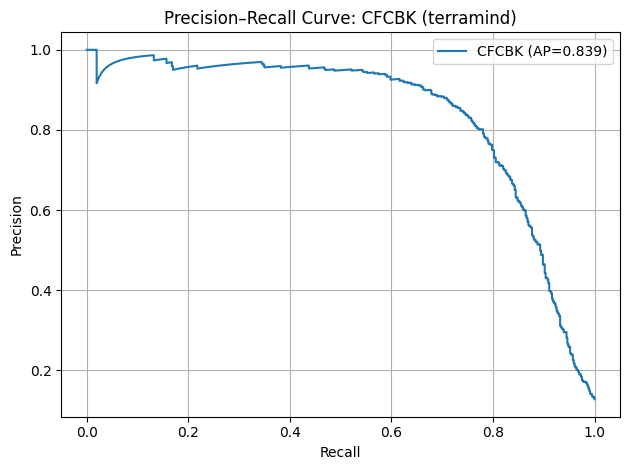

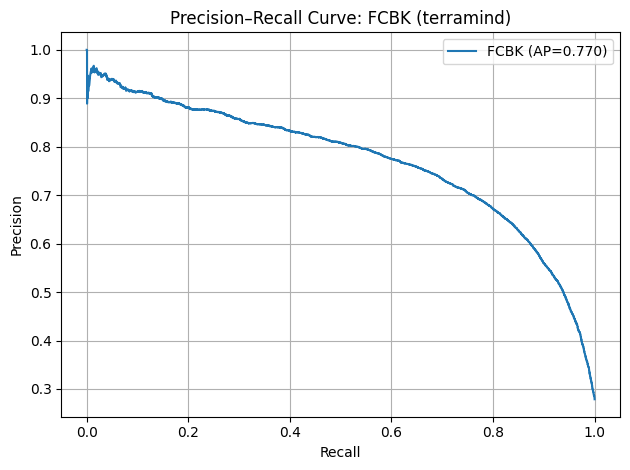

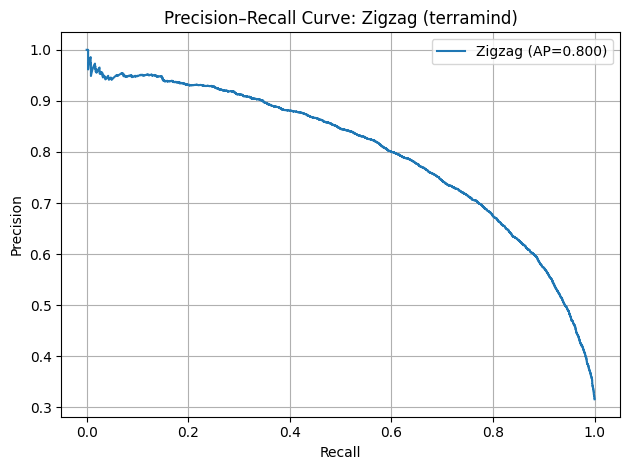


--- galileo ---


Processing test_results_galileo.csv: 100%|██████████| 15590/15590 [02:03<00:00, 125.91it/s]


| galileo | 13139 | 58869 | 846 | 0.182 | 0.940 | 0.306 |
Class CFCBK: TP=507, FP=2696, FN=140, Prec=0.158, Rec=0.784, F1=0.263


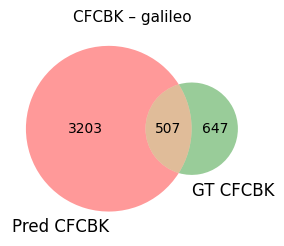

Class FCBK: TP=6955, FP=36733, FN=4153, Prec=0.159, Rec=0.626, F1=0.254


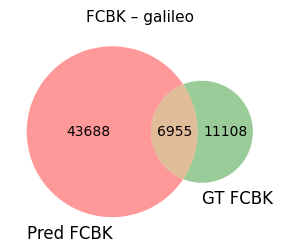

Class Zigzag: TP=5677, FP=26351, FN=3464, Prec=0.177, Rec=0.621, F1=0.276


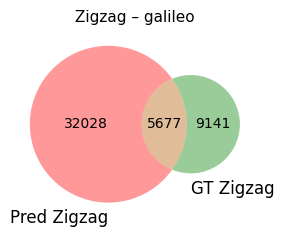

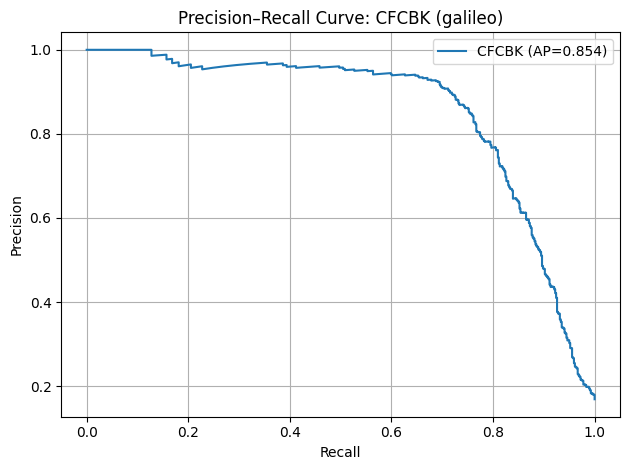

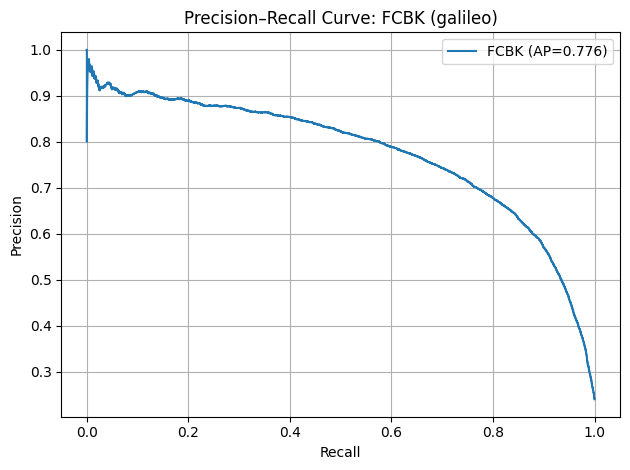

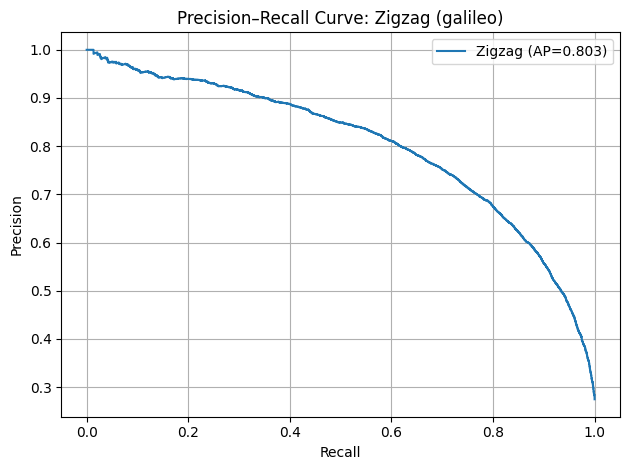


--- satmae ---


Processing test_results_satmae.csv: 100%|██████████| 15590/15590 [01:12<00:00, 215.54it/s]


| satmae | 14969 | 9813 | 2278 | 0.604 | 0.868 | 0.712 |
Class CFCBK: TP=375, FP=440, FN=272, Prec=0.460, Rec=0.580, F1=0.513


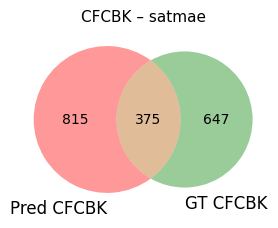

Class FCBK: TP=7907, FP=7212, FN=3201, Prec=0.523, Rec=0.712, F1=0.603


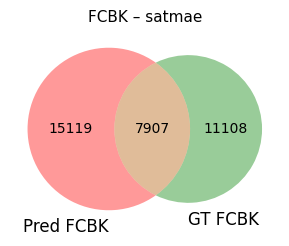

Class Zigzag: TP=6687, FP=5810, FN=2454, Prec=0.535, Rec=0.732, F1=0.618


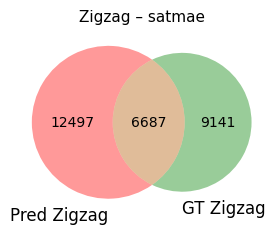

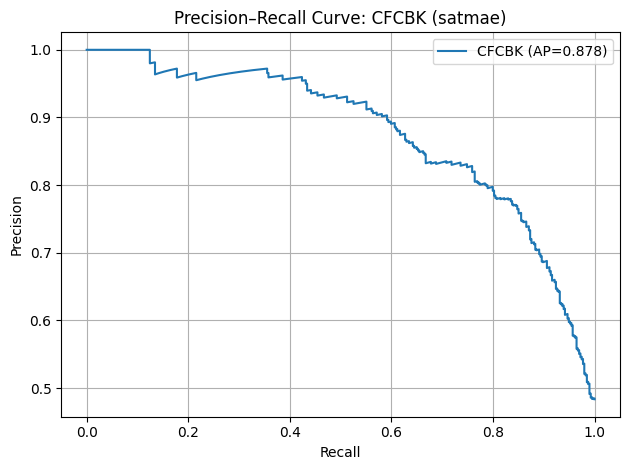

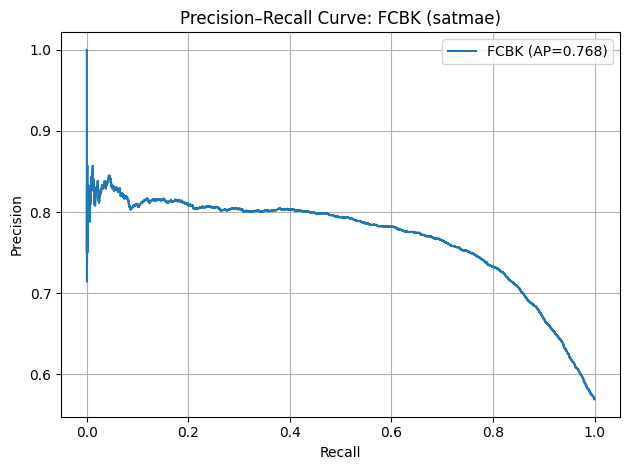

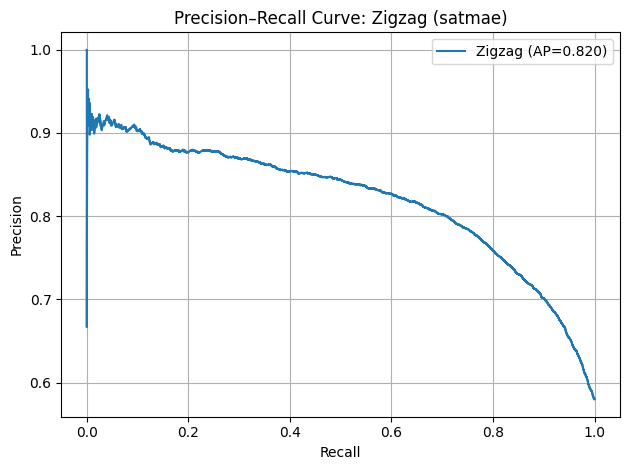

In [8]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.metrics import precision_recall_curve, auc

def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05):
    df = pd.read_csv(csv_path)
    image_names = sorted(df['image_name'].unique())
    targets, predictions = [], []

    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
        img_df = df[df['image_name'] == img_name]

        # --- Ground Truth ---
        gt_df = img_df[img_df['box_type'] == 'ground_truth']
        if not gt_df.empty:
            gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            gt_class_ids = (gt_df['class_id'].values - 1).astype(int)
            gt_confidence = np.ones(len(gt_class_ids), dtype=np.float32)
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_class_ids,
                confidence=gt_confidence
            )
        else:
            gt_detections = sv.Detections.empty()
        targets.append(gt_detections)

        # --- Predictions ---
        pred_df = img_df[img_df['box_type'] == 'prediction']
        pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]
        if not pred_df.empty:
            pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            pred_class_ids = (pred_df['class_id'].values - 1).astype(int)
            pred_scores = pred_df['confidence_score'].values
            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_class_ids,
                confidence=pred_scores
            )
        else:
            pred_detections = sv.Detections.empty()
        predictions.append(pred_detections)

    return predictions, targets

print("| Model | TP | FP | FN | Precision | Recall | F1 |")
print("|-------|----|----|----|-----------|--------|----|")

for model_name in MODEL_NAMES:
    print(f"\n--- {model_name} ---")
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    predictions, targets = load_detections_from_csv(csv_file, confidence_threshold=CONFIDENCE_THRESHOLD)

    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=CONFIDENCE_THRESHOLD,
        iou_threshold=IOU_THRESHOLD
    )
    cm = confusion_matrix.matrix

    tp = int(sum(cm[i, i] for i in range(NUM_CLASSES)))
    fp = int(cm[-1, :NUM_CLASSES].sum())
    fn = int(cm[:NUM_CLASSES, -1].sum())

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    print(f"| {model_name} | {tp} | {fp} | {fn} | {precision:.3f} | {recall:.3f} | {f1:.3f} |")

    for k in range(NUM_CLASSES):
        tp_k = int(cm[k, k])
        fp_k = int(cm[:, k].sum() - cm[k, k])
        fn_k = int(cm[k, :].sum() - cm[k, k])
        precision_k = tp_k / (tp_k + fp_k + 1e-9)
        recall_k = tp_k / (tp_k + fn_k + 1e-9)
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k + 1e-9)
        print(f"Class {CLASSES[k]}: TP={tp_k}, FP={fp_k}, FN={fn_k}, Prec={precision_k:.3f}, Rec={recall_k:.3f}, F1={f1_k:.3f}")

        gt_total = int(cm[k, :].sum())
        pred_total = int(cm[:, k].sum())
        tp = tp_k

        plt.figure(figsize=(3, 3))
        venn2(
            subsets=(pred_total, gt_total, tp),
            set_labels=(f"Pred {CLASSES[k]}", f"GT {CLASSES[k]}")
        )
        plt.title(f"{CLASSES[k]} – {model_name}", fontsize=11)
        plt.tight_layout()
        plt.show()

    # --- Class-wise PR Curves + AP ---
    for cls in range(NUM_CLASSES):
        all_scores = []
        all_labels = []

        for pred, gt in zip(predictions, targets):
            cls_preds = pred[cls == pred.class_id]
            cls_gts = gt[cls == gt.class_id]
            matched_gt_indices = set()
            matched_pred_indices = set()

            for i, pred_box in enumerate(cls_preds.xyxy):
                best_iou = 0
                best_gt_idx = -1
                for j, gt_box in enumerate(cls_gts.xyxy):
                    if j in matched_gt_indices:
                        continue
                    iou = box_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j
                if best_iou >= IOU_THRESHOLD:
                    matched_pred_indices.add(i)
                    matched_gt_indices.add(best_gt_idx)

            for i, score in enumerate(cls_preds.confidence):
                all_scores.append(score)
                all_labels.append(1 if i in matched_pred_indices else 0)

        if len(set(all_labels)) < 2:
            print(f"Skipping PR curve for class {CLASSES[cls]} due to insufficient label variety.")
            continue

        precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_scores)
        pr_auc = auc(recall_vals, precision_vals)

        plt.figure()
        plt.plot(recall_vals, precision_vals, label=f"{CLASSES[cls]} (AP={pr_auc:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve: {CLASSES[cls]} ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [9]:
import os
import pandas as pd

# Input paths
pred_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/notebooks/runs/detect/predict4/labels"
gt_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/aa_labels"
image_size = 128

# Class ID to name mapping
class_map = {
    0: "CFCBK",
    1: "FCBK",
    2: "Zigzag"
}

# Container for final rows
rows = []

# Iterate over predicted label files
for fname in os.listdir(pred_labels_dir):
    if not fname.endswith(".txt"):
        continue
    image_name = fname.replace(".txt", ".png")

    # Prediction labels
    with open(os.path.join(pred_labels_dir, fname), "r") as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            cx, cy, w, h, conf = map(float, parts[1:])
            xmin = (cx - w / 2) * image_size
            ymin = (cy - h / 2) * image_size
            xmax = (cx + w / 2) * image_size
            ymax = (cy + h / 2) * image_size
            rows.append([
                image_name, "prediction", cls_id, class_map[cls_id], conf,
                xmin, ymin, xmax, ymax
            ])

    # Ground truth labels
    gt_file_path = os.path.join(gt_labels_dir, fname)
    if os.path.exists(gt_file_path):
        with open(gt_file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                cx, cy, w, h = map(float, parts[1:])
                xmin = (cx - w / 2) * image_size
                ymin = (cy - h / 2) * image_size
                xmax = (cx + w / 2) * image_size
                ymax = (cy + h / 2) * image_size
                rows.append([
                    image_name, "ground_truth", cls_id, class_map[cls_id], 1.0,
                    xmin, ymin, xmax, ymax
                ])

# Convert to DataFrame
df = pd.DataFrame(rows, columns=[
    "image_name", "box_type", "class_id", "class_name",
    "confidence_score", "bbox_xmin", "bbox_ymin", "bbox_xmax", "bbox_ymax"
])

# import caas_jupyter_tools as cj
# cj.display_dataframe_to_user(name="YOLO Converted CSV", dataframe=df)


In [10]:
display(df)

,image_name,box_type,class_id,class_name,confidence_score,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,31.3041_72.9763.png,prediction,1,FCBK,0.821111,70.911994,43.755898,81.962758,54.091142
1,31.3041_72.9763.png,prediction,1,FCBK,0.632193,120.186874,64.514490,128.067846,75.061062
2,31.3041_72.9763.png,prediction,1,FCBK,0.085310,117.596064,49.274003,127.906144,58.556781
3,31.3041_72.9763.png,prediction,1,FCBK,0.053606,52.578483,1.776307,61.642317,10.927795
4,31.3041_72.9763.png,ground_truth,1,FCBK,1.000000,70.075200,43.189248,81.971392,54.091520
...,...,...,...,...,...,...,...,...,...
48816,29.6643_77.2661.png,prediction,1,FCBK,0.389290,88.694074,19.960928,101.265862,30.829472
48817,29.6643_77.2661.png,prediction,1,FCBK,0.120661,74.707853,0.355002,86.155379,11.314042
48818,29.6643_77.2661.png,prediction,1,FCBK,0.124350,75.470598,109.968621,87.113722,120.645907
48819,29.6643_77.2661.png,prediction,1,FCBK,0.083403,-0.048173,89.347789,4.610016,99.130163


In [17]:
import os
import pandas as pd

# Input paths
pred_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/notebooks/runs/detect/predict4/labels"
gt_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/aa_labels"
image_size = 128

# Class ID to name mapping
class_map = {
    0: "CFCBK",
    1: "FCBK",
    2: "Zigzag"
}

# Container for final rows
rows = []

# Iterate over all label files (based on prediction directory)
for fname in sorted(os.listdir(pred_labels_dir)):
    if not fname.endswith(".txt"):
        continue
    image_name = fname.replace(".txt", ".png")

    # Ground truth labels first
    gt_file_path = os.path.join(gt_labels_dir, fname)
    if os.path.exists(gt_file_path):
        with open(gt_file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                cx, cy, w, h = map(float, parts[1:])
                xmin = (cx - w / 2) * image_size
                ymin = (cy - h / 2) * image_size
                xmax = (cx + w / 2) * image_size
                ymax = (cy + h / 2) * image_size
                rows.append([
                    image_name, "ground_truth", cls_id, class_map[cls_id], 1.0,
                    xmin, ymin, xmax, ymax
                ])

    # Prediction labels next
    pred_file_path = os.path.join(pred_labels_dir, fname)
    with open(pred_file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            cx, cy, w, h, conf = map(float, parts[1:])
            xmin = (cx - w / 2) * image_size
            ymin = (cy - h / 2) * image_size
            xmax = (cx + w / 2) * image_size
            ymax = (cy + h / 2) * image_size
            rows.append([
                image_name, "prediction", cls_id, class_map[cls_id], conf,
                xmin, ymin, xmax, ymax
            ])

# Convert to DataFrame
df = pd.DataFrame(rows, columns=[
    "image_name", "box_type", "class_id", "class_name",
    "confidence_score", "bbox_xmin", "bbox_ymin", "bbox_xmax", "bbox_ymax"
])

# import caas_jupyter_tools as cj
# cj.display_dataframe_to_user(name="YOLO Converted CSV", dataframe=df)


In [18]:
display(df)

,image_name,box_type,class_id,class_name,confidence_score,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,20.9547_72.9148.png,ground_truth,0,CFCBK,1.000000,66.779136,32.169920,73.296128,38.278208
1,20.9547_72.9148.png,prediction,0,CFCBK,0.473481,65.906669,31.576294,73.459219,38.297370
2,20.9547_72.9148.png,prediction,1,FCBK,0.311399,56.560410,24.909376,66.652646,30.426304
3,20.9547_72.9148.png,prediction,1,FCBK,0.137809,125.235206,62.848928,128.027642,70.359392
4,20.9547_72.9148.png,prediction,1,FCBK,0.126998,97.549229,124.404570,104.327507,128.007846
...,...,...,...,...,...,...,...,...,...
134686,34.4099_71.8548.png,ground_truth,1,FCBK,1.000000,80.476096,70.707264,94.261056,80.228544
134687,34.4099_71.8548.png,prediction,1,FCBK,0.829682,80.369664,70.103994,93.352192,79.404358
134688,34.4099_71.8548.png,prediction,1,FCBK,0.076780,103.955770,86.692947,114.111942,97.084589
134689,34.4099_71.8548.png,prediction,1,FCBK,0.062413,29.663514,111.086259,38.385126,120.845389


In [21]:
df.to_csv("abc.csv", index=False)
